# NLP : Classify names with RNN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim 
import numpy as np
import glob
import string
import random

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure, imshow, axis


In [ ]:
valid_letters = string.ascii_letters + " ',.;"
num_letters = len(valid_letters)
batch_size = 5

import unicodedata
def unicode_to_ascii(name):
    return ''.join(
        c for c in unicodedata.normalize('NFD', name)
        if unicodedata.category(c) != 'Mn'
        and c in valid_letters
    )  

'''
  Load data file. Each file contains the list of unique names. 
  Returns a list of labels and a dictionary pointing names 
  e.g. 'Korean'-> 'Park','Choi' , ... etc
'''
def load_data():
  name_label = []
  name_data = {}
  filenames = glob.glob('*.txt')

  for file in filenames:
    label = file.split('.txt')[0]
    name_label.append(label) 
    text_data = open(file,encoding='utf-8').read().strip().split('\n')
    name_data[label] = [unicode_to_ascii(name) for name in text_data]
  return name_label, name_data
  

In [ ]:
def word_to_onehot(X): 
  fe = torch.zeros(len(X),1, num_letters)
  for idx,c in enumerate(X):
    fe[idx][0][valid_letters.find(c)] = 1
  return fe

In [ ]:
feature = word_to_onehot('Jane')
print(feature)
print(feature.shape)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

# Define Recurrent Nerual Network - sentiment classfication

In [ ]:
class RNN(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(RNN,self).__init__()

    self.i2o = nn.Linear(input_dim + hidden_dim, output_dim)
    self.i2h = nn.Linear(input_dim + hidden_dim, hidden_dim)
    self.tan = nn.LogSoftmax(dim=1)

  def forward(self, X, last_hidden):
    input = torch.cat((X,last_hidden),dim = 1)
    out = self.i2o(input)
    out = self.tan(out)
    hidden = self.i2h(input)
    return hidden, out


In [ ]:
def train(name_label,name_data):
  
  learning_rate = 0.0092
  avg_loss = []
  loss_item = []
  train_loss =0
  rnn = RNN(num_letters,128, len(name_label))
  loss_func = nn.NLLLoss()
  optimizer = torch.optim.SGD(rnn.parameters(), lr = learning_rate)
  
  for i in range(0, 40000,1):
    if i > 0 and i % 20 == 0:
      avg_loss.append(train_loss/20)
      train_loss = 0
    
    hidden = torch.zeros(1,128)
    optimizer.zero_grad()
    train_label = random.choice(name_label)
    train_name = random.choice(name_data[train_label])
    tensor_name = word_to_onehot(train_name)
    label = torch.tensor([name_label.index(train_label)],dtype=torch.long)

    for idx in range(0,tensor_name.shape[0],1):
      hidden, output = rnn(tensor_name[idx],hidden)

    loss = loss_func(output,label)
    train_loss += loss
    loss.backward()
    optimizer.step()
  return rnn,avg_loss

In [ ]:
torch.tensor()

In [ ]:
def evaluate(rnn,name_label,name_data):
  correct = 0
  item = []
  for i in range(0, 10000,1):
    hidden = torch.zeros(1,128)
    train_label = random.choice(name_label)
    train_name = random.choice(name_data[train_label])
    tensor_name = word_to_onehot(train_name)
    label = torch.tensor([name_label.index(train_label)],dtype=torch.long)

    for idx in range(0,tensor_name.shape[0],1):
      hidden, output = rnn(tensor_name[idx],hidden)
    
    prediction = torch.argmax(output.data)
    if prediction == name_label.index(train_label):
      correct += 1
    item.append([train_name, train_label, name_label[prediction]])
  return correct / 10000, item

In [ ]:
def eval_name(rnn,name):
  hidden = torch.zeros(1,128)
  tensor_name = word_to_onehot(name)

  for idx in range(0,tensor_name.shape[0],1):
    hidden, output = rnn(tensor_name[idx],hidden)
    
    prediction = torch.argmax(output.data)
  return prediction, rnn

Test accuracy: 0.5362
Langlais / French  was predicted as  Greek
Doherty / Irish  was predicted as  Irish
Lim  / Korean  was predicted as  Japanese
Nakamura / Japanese  was predicted as  Japanese
Kreisinger / Czech  was predicted as  German
Choi / Korean  was predicted as  Korean
Mclean / Scottish  was predicted as  Scottish
Nezametdinov / Russian  was predicted as  Russian
Choshi / Japanese  was predicted as  Japanese


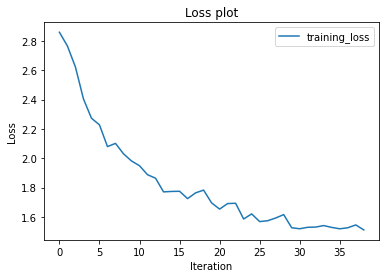

In [ ]:
if __name__ ==  "__main__":
  hidden_dim = 128
  name_label, name_data = load_data()
  rnn, avg_loss = train(name_label,name_data)
  
  # evaluate model on validation data
  accuracy,item = evaluate(rnn,name_label,name_data)  
  print("Test accuracy: {}".format(accuracy))
  
  for name, label, predict in item[:9]:
    print(name,'/', label,' was predicted as ', predict )
  # plot losses
  plt.plot(avg_loss)
  plt.legend(["training_loss","validation_loss"])
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.title("Loss plot")
  plt.show()

In [ ]:
  test_name = ["Choi","Min","Hwang", "Choo", "Son","Han","Sam", "Matt", "Paul", "Newton", "Muhamad", "Albert", "Alberto", "Marco"]
  for test in test_name:
    result,rnn = eval_name(rnn, test)
    print(test, " was predicted as ", name_label[result])

Choi  was predicted as  Korean
Min  was predicted as  Chinese
Hwang  was predicted as  Korean
Choo  was predicted as  Korean
Son  was predicted as  Korean
Han  was predicted as  Chinese
Sam  was predicted as  Korean
Matt  was predicted as  German
Paul  was predicted as  Vietnamese
Newton  was predicted as  Scottish
Muhamad  was predicted as  Arabic
Albert  was predicted as  French
Alberto  was predicted as  Portuguese
Marco  was predicted as  Portuguese
